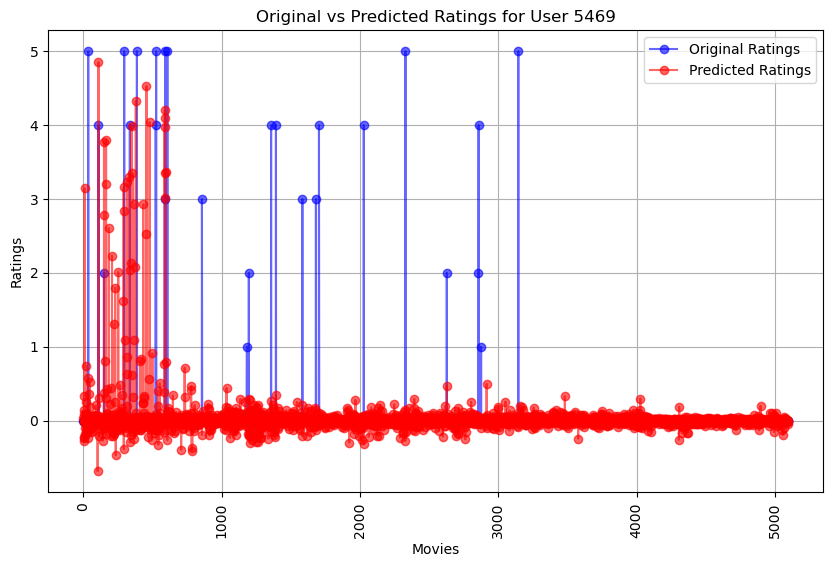

U Matrix Shape: (7119, 100)
Sigma Matrix Shape: (100, 100)
Vt Matrix Shape: (100, 4837)

Top 7 Recommended Movies for User 5469 (based on preferences: fantasy, action):
Die Hard: With a Vengeance (1995): ★★★★★ (Rating: 4.5)
Clear and Present Danger (1994): ★★★★☆ (Rating: 4.3)
Forrest Gump (1994): ★★★★☆ (Rating: 4.0)
True Lies (1994): ★★★★☆ (Rating: 4.0)
Fugitive, The (1993): ★★★★☆ (Rating: 3.8)
Jurassic Park (1993): ★★★☆☆ (Rating: 3.4)
Batman (1989): ★★★☆☆ (Rating: 3.3)


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
import random

# Load datasets
movies = pd.read_csv('C:\\Users\\Bhoomika Swamy\\Downloads\\Movie_Data.csv', encoding='ISO-8859-1')
ratings = pd.read_csv('C:\\Users\\Bhoomika Swamy\\Downloads\\Ratings_Data.csv', encoding='ISO-8859-1')
tags = pd.read_csv('C:\\Users\\Bhoomika Swamy\\Downloads\\Tags_Data.csv', encoding='ISO-8859-1')

# Prepare the user-movie ratings matrix
user_movie_ratings = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Convert the user_movie_ratings DataFrame into a sparse matrix
user_movie_ratings_sparse = csr_matrix(user_movie_ratings.values)

# Apply SVD to the User-Movie ratings matrix
k_value = 100  # Choose k based on previous analysis or Elbow method
U, sigma, Vt = svds(user_movie_ratings_sparse, k=k_value)
sigma = np.diag(sigma)

# Reconstruct the matrix for predictions
reconstructed_ratings = np.dot(np.dot(U, sigma), Vt)

# Convert the matrix back to DataFrame for easy interpretation
predicted_ratings_df = pd.DataFrame(reconstructed_ratings, columns=user_movie_ratings.columns)

# Define a function to recommend movies with user-specified preferences (genre, tags, etc.)
def recommend_movies_with_preferences(user_id, preferred_tags=[], num_recommendations=10):
    # Get the user's original ratings (actual ratings given by the user)
    original_ratings = user_movie_ratings.loc[user_id]
    
    # Predicted ratings from SVD
    predicted_ratings = pd.Series(reconstructed_ratings[user_id - 1], index=user_movie_ratings.columns)

    # Separate rated and unrated movies
    unrated_movies = original_ratings[original_ratings == 0].index
    
    # Recommend unrated movies based on predicted ratings
    top_predicted_movies = predicted_ratings[unrated_movies].sort_values(ascending=False)[:num_recommendations]
    
    # Filter movies based on user preferences (genre, tags, etc.)
    if preferred_tags:
        # Get movie IDs for movies that match the preferred tags
        matching_movies = tags[tags['tag'].isin(preferred_tags)]['movieId'].unique()
        top_predicted_movies = top_predicted_movies[top_predicted_movies.index.isin(matching_movies)]
    
    # Get movie titles from the movies DataFrame and add the corresponding predicted rating
    recommended_movies_df = movies[movies['movieId'].isin(top_predicted_movies.index)].copy()
    recommended_movies_df['rating'] = top_predicted_movies.values

    return recommended_movies_df[['title', 'rating']].sort_values(by='rating', ascending=False)

# Test the function with a randomly selected user and preferred tags (e.g., 'fantasy', 'action')
user_id = random.choice(user_movie_ratings.index)
preferred_tags = ['fantasy', 'action']  # Example of user preferences

recommended_movies = recommend_movies_with_preferences(user_id, preferred_tags=preferred_tags, num_recommendations=10)

# Visualize the original vs predicted ratings for the selected user
def plot_user_ratings(user_id):
    original_ratings = user_movie_ratings.loc[user_id]
    predicted_ratings = pd.Series(reconstructed_ratings[user_id - 1], index=user_movie_ratings.columns)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(original_ratings.index, original_ratings, label='Original Ratings', marker='o', color='blue', alpha=0.6)
    plt.plot(predicted_ratings.index, predicted_ratings, label='Predicted Ratings', marker='o', color='red', alpha=0.6)
    
    plt.xlabel('Movies')
    plt.ylabel('Ratings')
    plt.title(f'Original vs Predicted Ratings for User {user_id}')
    plt.xticks(rotation=90)  # Rotate movie titles for better readability
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot user rating comparison for the randomly selected user
plot_user_ratings(user_id)

# Print the SVD matrices
print("U Matrix Shape:", U.shape)
print("Sigma Matrix Shape:", sigma.shape)
print("Vt Matrix Shape:", Vt.shape)

# Display recommended movies with star ratings
def colored_stars(rating):
    stars = '★' * int(np.round(rating)) + '☆' * (5 - int(np.round(rating)))  # Create star representation
    return f"\033[91m{stars}\033[0m"  # ANSI escape code for red
def bold_text(text):
    return f"\033[1m{text}\033[0m"  # ANSI escape code for bold
    
# Display top 10 recommended movie titles with user preferences
print(f"\nTop {len(recommended_movies)} Recommended Movies for User {user_id} (based on preferences: {', '.join(preferred_tags)}):")
for _, row in recommended_movies.head(10).iterrows():  # Get top 10
    title = row['title']
    rating = row['rating']
    stars = colored_stars(rating)  # Get colored stars
    bold_title = bold_text(title)  # Get bold title
    print(f"{bold_title}: {stars} (Rating: {rating:.1f})")


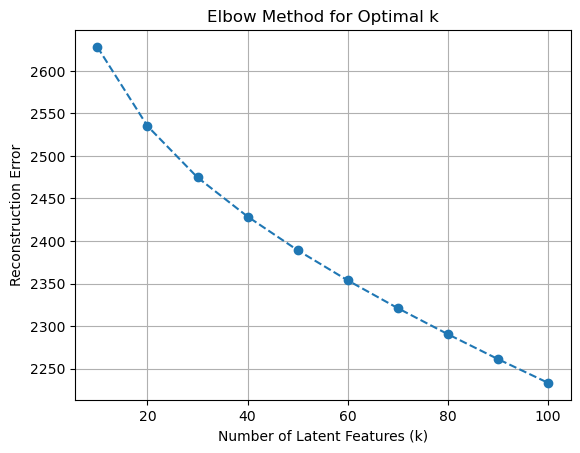

Optimal k value: 100


In [13]:
# Calculate total reconstruction error for different k values (Elbow Method)
def calculate_optimal_k(user_movie_ratings_sparse, max_k=1000):
    errors = []
    ks = range(10, max_k + 1, 10)  # Testing for k from 10 to max_k with steps of 10
    for k in ks:
        # Perform SVD
        U, sigma, Vt = svds(user_movie_ratings_sparse, k=k)
        sigma = np.diag(sigma)
        
        # Reconstruct the ratings matrix
        reconstructed_ratings = np.dot(np.dot(U, sigma), Vt)
        
        # Calculate reconstruction error (Frobenius norm of the difference)
        error = np.linalg.norm(user_movie_ratings_sparse.toarray() - reconstructed_ratings, ord='fro')
        errors.append(error)
    
    # Plot the error vs. k values
    plt.plot(ks, errors, marker='o', linestyle='--')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Latent Features (k)')
    plt.ylabel('Reconstruction Error')
    plt.grid(True)
    plt.show()

    # Return the best k (elbow point could be selected manually)
    return ks[np.argmin(errors)]

# Calculate the optimal k value
optimal_k = calculate_optimal_k(user_movie_ratings_sparse, max_k=100)
print(f"Optimal k value: {optimal_k}")
